In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt, numpy as np, pandas as pd
np.random.seed(311)

In [ ]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

x = np.concatenate((np.ones((506, 1)), data), axis=1)
N = x.shape[0]
d = x.shape[1]
y = target

idx = np.random.permutation(range(N))

In [ ]:
def l2(A, B):
    '''
    Input:  A is a N x d matrix
            B is a M x d matirx
    Output: dist is a N x M matrix where dist[i,j] is the square norm between A[i,:] and B[j,:], i.e. dist[i,j] = ||A[i,:]-B[j,:]||^2
    '''
    A_norm = (A**2).sum(axis=1).reshape(A.shape[0],1)
    B_norm = (B**2).sum(axis=1).reshape(1,B.shape[0])
    dist = A_norm+B_norm-2*A.dot(B.transpose())
    return dist

In [ ]:
def LRLS(test_datum, x_train, y_train, tau, lam=1e-5):
    '''
    Input:  test_datum is a d x 1 test vector
            x_train is the N_train x d design matrix
            y_train is the N_train x 1 targets vector
            tau is the local reweighting parameter
            lam is the regularization parameter
    Output: y_hat is the prediction on test_datum
    '''
    N_train = len(x_train)
    test_datum = np.reshape(test_datum, (d, 1))
    dist = l2(test_datum.T, x_train).flatten()

    a_top = np.exp(-dist/(2*tau**2))
    a_bottom = np.sum(np.exp(-dist / (2*tau**2)))
    a = [a_top[i]/a_bottom for i in range(N_train)]

    A = np.diag(a)
    lamI = lam*np.identity(d)
    w_star = np.linalg.solve((np.dot(x_train.T, np.dot(A, x_train)) + lamI), np.dot(x_train.T, np.dot(A, y_train)))

    return np.dot(test_datum.T, w_star)

In [ ]:
def run_validation(x, y, taus, val_frac):
    '''
    Input:  x is the N x d design matrix
            y is the N x 1 targets vector
            taus is a vector of tau values to evaluate
            val_frac is the fraction of examples to use as validation data
    Output: a vector of training losses, one for each tau value
            a vector of validation losses, one for each tau value
    '''

    training_count = int(np.round(0.7*N))
    x_train, x_valid = x[idx[:training_count],:], x[idx[training_count:],:]
    y_train, y_valid = y[idx[:training_count],], y[idx[training_count:],]
    N_train = len(x_train)
    N_valid = len(x_valid)

    train_losses = []; valid_losses = []

    for tau in taus:
        train_loss = 0; valid_loss = 0

        for i in range(N_train):
            y_hat = LRLS(x_train[i], x_train, y_train, tau)
            train_loss += 1/2*((y_hat-y_train[i])**2)

        for i in range(N_valid):
            y_hat = LRLS(x_valid[i], x_train, y_train, tau)
            valid_loss += 1/2*((y_hat-y_valid[i])**2)

        train_losses.append(float(train_loss/N_train))
        valid_losses.append(float(valid_loss/N_valid))

    return train_losses, valid_losses

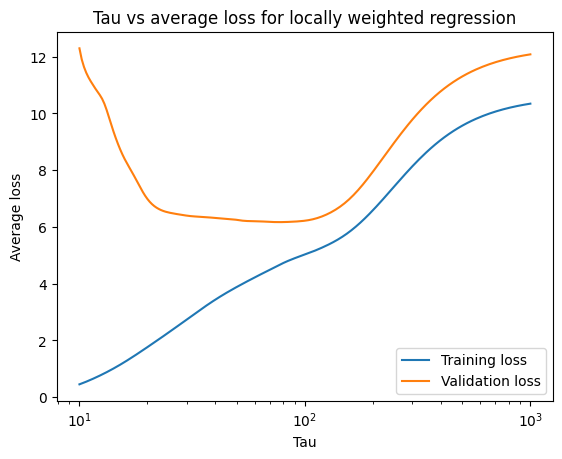

In [ ]:
if __name__ == "__main__":
    taus = np.logspace(1.0,3,200)
    train_losses, test_losses = run_validation(x,y,taus,val_frac=0.3)

    plt.semilogx(taus, train_losses, label="Training loss")
    plt.semilogx(taus, test_losses, label="Validation loss")
    plt.legend()
    plt.title("Tau vs average loss for locally weighted regression")
    plt.xlabel("Tau"); plt.ylabel("Average loss")